In [1]:
import os
from collections import Counter

import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

from tensorflow import keras, config
# Configure GPU memory to run alongside other training tasks
gpus = config.experimental.list_physical_devices('GPU')
config.experimental.set_virtual_device_configuration(gpus[0], [config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 8)]) # 1024MB * 8 = 8GB
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Hide tf warnings
from keras.models import load_model

from cascid.datasets.pad_ufes.database import get_images_with_no_metadata
from cascid.datasets.isic.database import get_train_test_images_raw, get_train_test_images_hairless, get_train_test_images_hairless_quantized
from cascid.datasets.pad_ufes import images as pad_ufes_images, database as pad_ufes_db
from cascid.configs.config import DATA_DIR

2022-11-21 08:30:38.456168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 08:30:38.661645: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 08:30:39.399554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-21 08:30:39.399632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## PAD-UFES

In [2]:
pad_ufes_vals_raw = dict()
pad_ufes_vals_hairless = dict()
pad_ufes_vals_hq = dict()
# df
categories = [np.array(sorted(['Cancer', "Not"]), dtype='object')]
ohe = OneHotEncoder(sparse=False, categories=categories, handle_unknown="ignore")

_, pad_ufes_vals_raw['x_test'], _, pad_ufes_vals_raw['y_test'] = pad_ufes_db.get_train_test_images_raw()
pad_ufes_vals_raw['y_test'] = ['Cancer' if x in ['MEL', 'BCC', 'SCC'] else 'Not' for x in pad_ufes_vals_raw['y_test'].flatten()]
ohe.fit(np.array(pad_ufes_vals_raw['y_test']).reshape(-1,1))

_, pad_ufes_vals_hairless['x_test'], _, pad_ufes_vals_hairless['y_test'] = pad_ufes_db.get_train_test_images_hairless()
pad_ufes_vals_hairless['y_test'] = ['Cancer' if x in ['MEL', 'BCC', 'SCC'] else 'Not' for x in pad_ufes_vals_hairless['y_test'].flatten()]

_, pad_ufes_vals_hq['x_test'], _, pad_ufes_vals_hq['y_test'] = pad_ufes_db.get_train_test_images_hairless_quantized()
pad_ufes_vals_hq['y_test'] = ['Cancer' if x in ['MEL', 'BCC', 'SCC'] else 'Not' for x in pad_ufes_vals_hq['y_test'].flatten()]

## ISIC

In [3]:
isic_vals_raw = dict()
# df
_, isic_vals_raw['x_test'], _, isic_vals_raw['y_test'] = get_train_test_images_raw()
isic_vals_raw['y_test'] = list(map(lambda x: "Cancer" if x in ["MEL", "SCC", "BCC"] else "Not", isic_vals_raw['y_test'].flatten()))

isic_vals_hairless = dict()
# df
_, isic_vals_hairless['x_test'], _, isic_vals_hairless['y_test'] = get_train_test_images_hairless()
isic_vals_hairless['y_test'] = list(map(lambda x: "Cancer" if x in ["MEL", "SCC", "BCC"] else "Not", isic_vals_hairless['y_test'].flatten()))

isic_vals_hq = dict()
# df
_, isic_vals_hq['x_test'], _, isic_vals_hq['y_test'] = get_train_test_images_hairless_quantized()
isic_vals_hq['y_test'] = list(map(lambda x: "Cancer" if x in ["MEL", "SCC", "BCC"] else "Not", isic_vals_hq['y_test'].flatten()))

## Evaluation

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues, save_to_file = False):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true' if normalize else None)
    
    #print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.3f' if normalize else 'd'
    thresh = cm.mean()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig('Assets/files/' + title + '.pdf')
    return ax

In [5]:
def evaluate_model_performance(model: keras.models.Sequential, title:str, x_test, y_test):
    y_pred = model.predict(x_test, verbose=0)
    y_pred = ohe.inverse_transform(y_pred).flatten()
    acc = accuracy_score(y_test, y_pred)
    if acc < 0.5:
        y_pred_fixed = ["Not" if x == "Cancer" else "Cancer" for x in y_pred]
        acc = 1-acc
    else:
        y_pred_fixed = y_pred
    # print("Model accuracy for {}: {:.3f}%".format(title, 100*acc))
    plot_confusion_matrix(
        y_true=y_test,
        y_pred=y_pred_fixed,
        classes=ohe.categories_[0].tolist(),
        normalize=True,
        title=title
    );
    return acc

#### MODELS ON PAD-UFES

2022-11-21 08:30:45.314981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 08:30:45.315569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 08:30:45.316912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 08:30:45.317459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Class ratio is 50.870%
Isic-on-Pad
final_isic_resnet18_aug_raw:		0.6891304347826087
final_isic_resnet34_aug_hairless:		0.6652173913043479
final_isic_resnet34_aug_raw:		0.6326086956521739
final_isic_resnet18_noaug_hairless:		0.6065217391304348
final_isic_resnet18_aug_hq:		0.5956521739130435
final_isic_resnet18_aug_hairless:		0.5652173913043478
final_isic_resnet34_noaug_hq:		0.558695652173913
final_isic_resnet18_noaug_hq:		0.558695652173913
final_isic_resnet34_noaug_hairless:		0.55
final_isic_resnet34_noaug_raw:		0.5413043478260869
final_isic_resnet18_noaug_raw:		0.5304347826086957
Pad-on-Pad
final_pad_ufes_resnet34_aug_raw:		0.7891304347826087
final_pad_ufes_resnet18_aug_raw:		0.7804347826086957
final_pad_ufes_resnet18_aug_hq:		0.7739130434782608
final_pad_ufes_resnet34_aug_hairless:		0.7521739130434782
final_pad_ufes_resnet18_aug_hairless:		0.7478260869565218
final_pad_ufes_resnet34_noaug_raw:		0.7108695652173913
final_pad_ufes_resnet34_noaug_hairless:		0.7065217391304348
final_pad_ufe

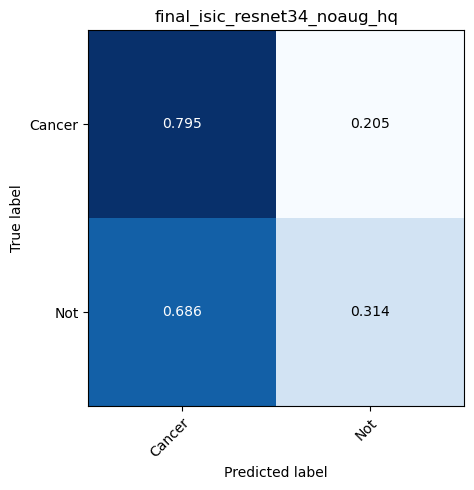

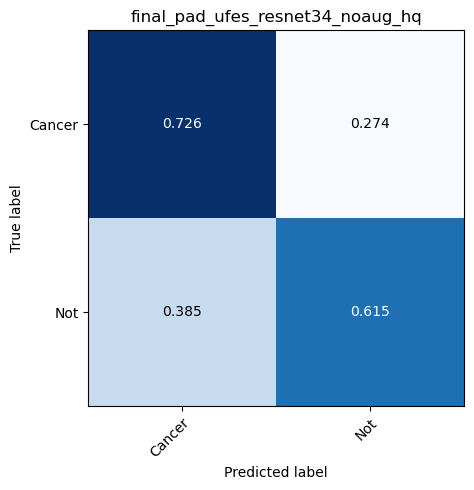

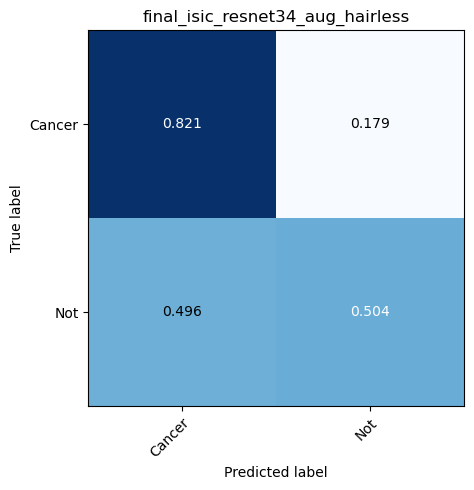

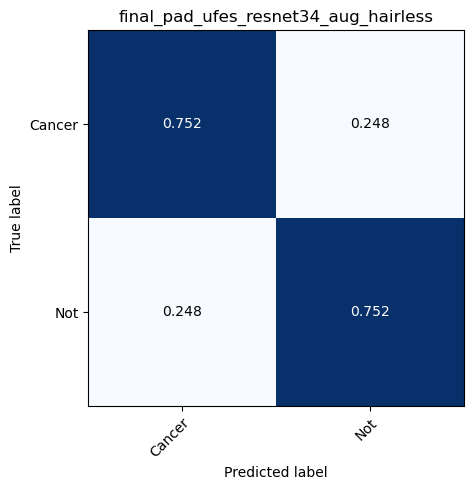

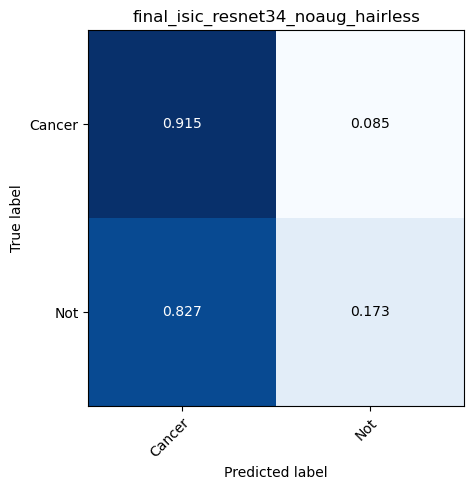

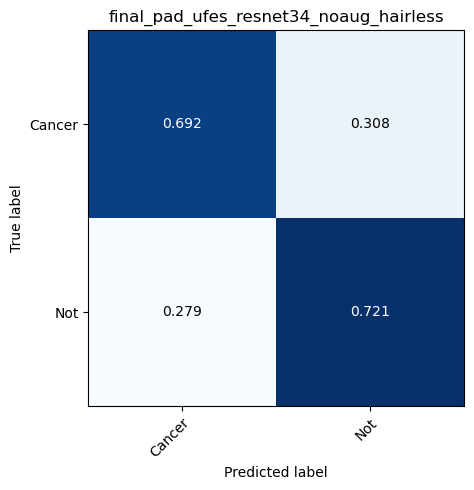

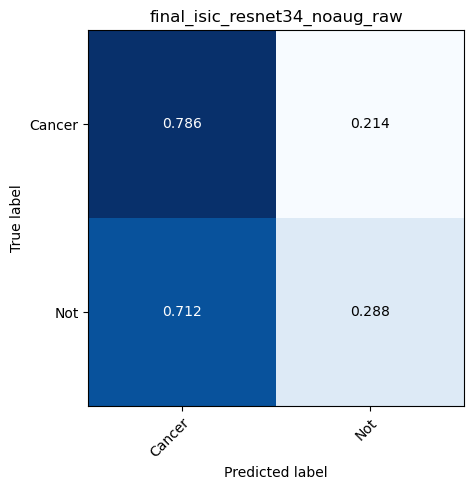

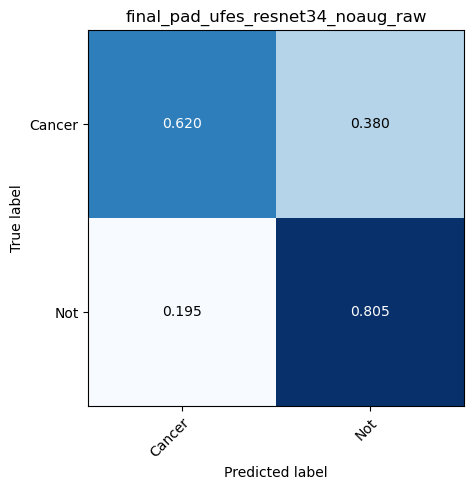

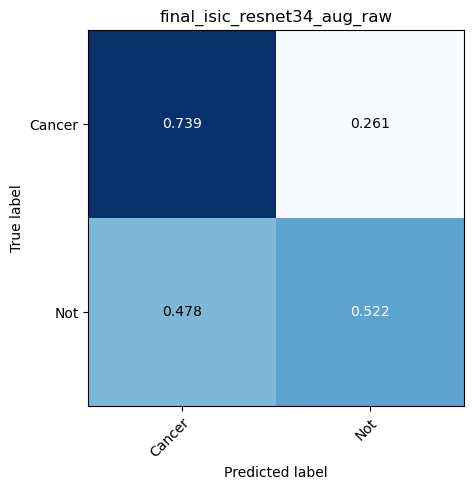

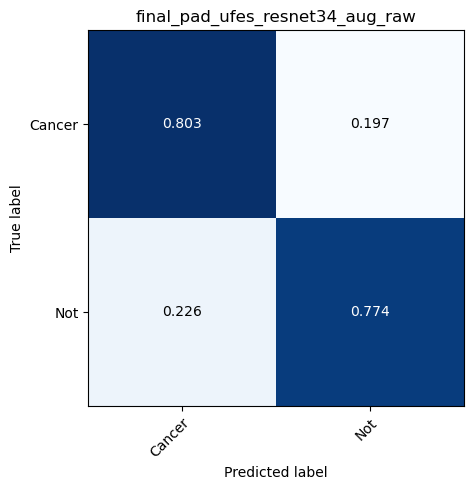

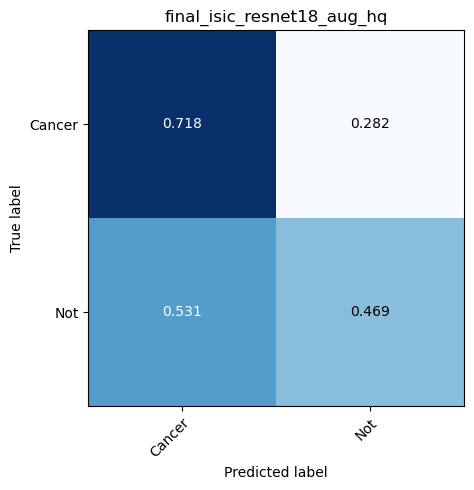

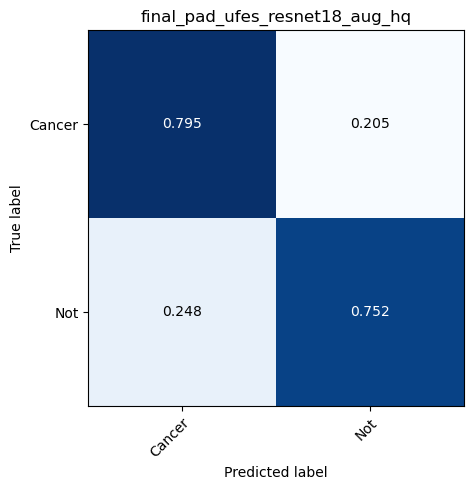

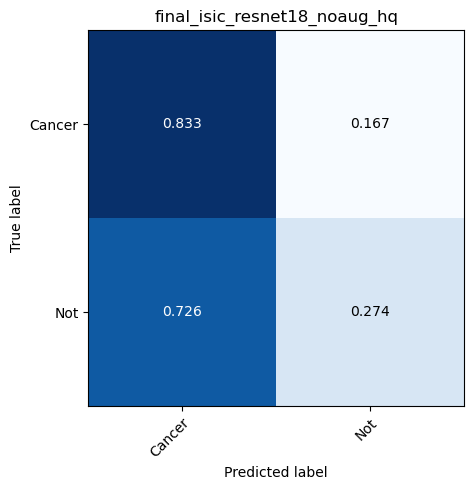

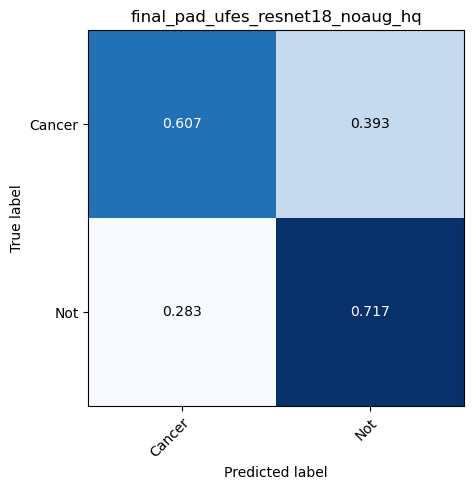

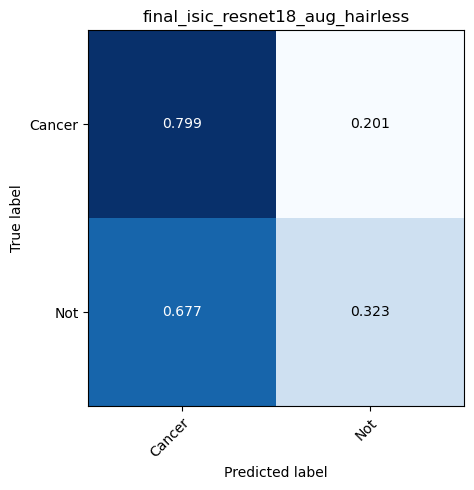

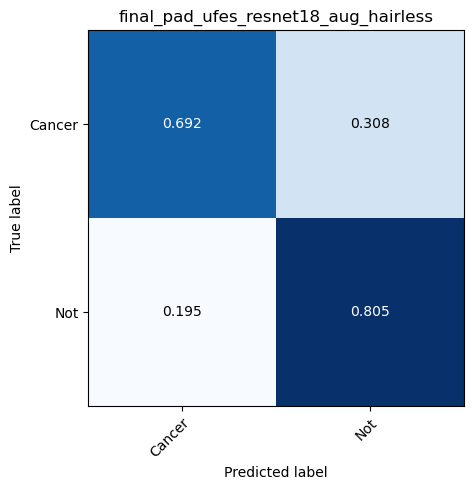

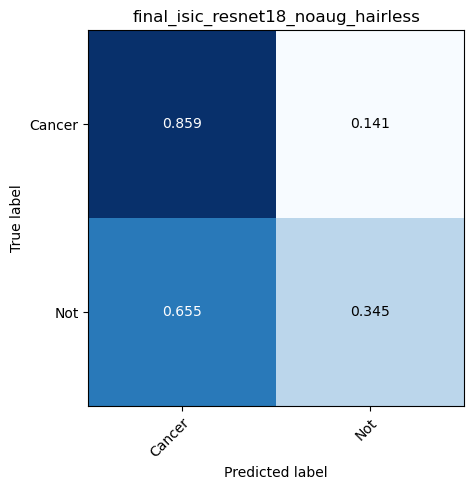

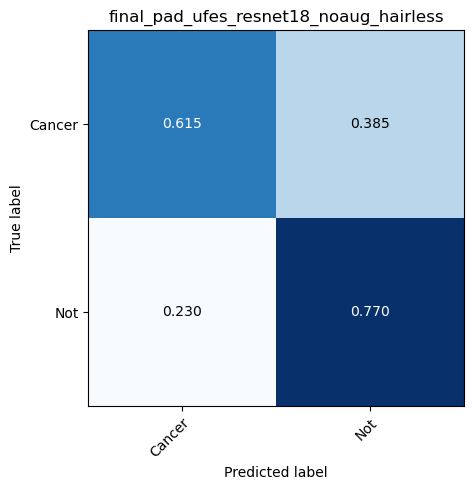

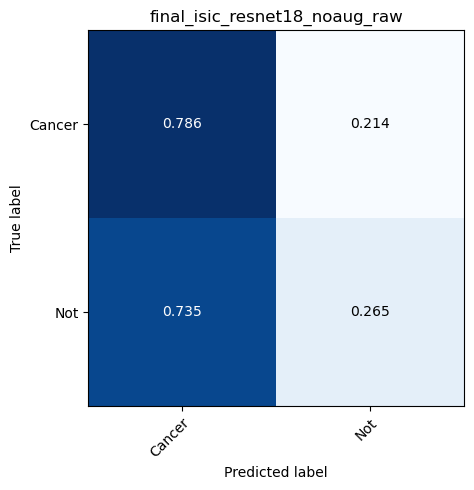

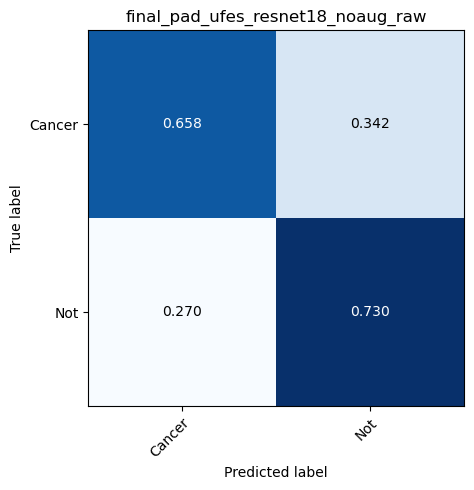

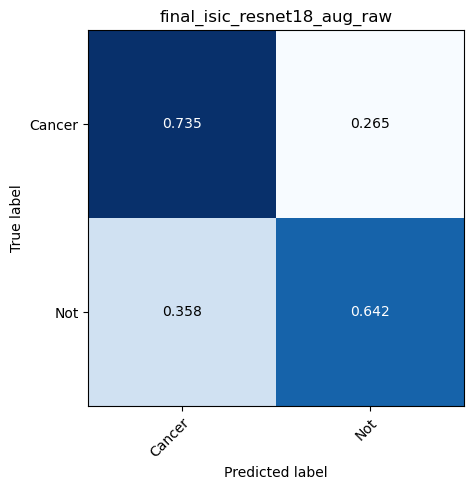

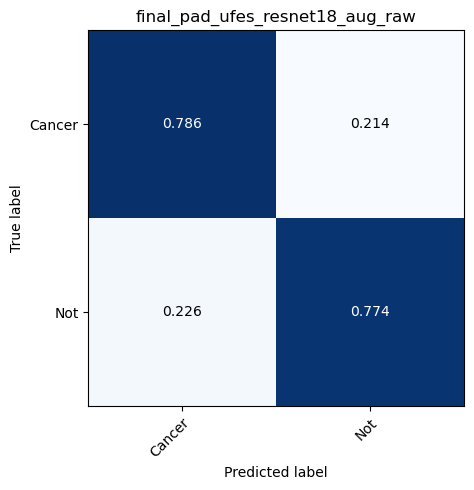

In [6]:
total_dict = dict()
EXPERIMENT_DIR = DATA_DIR / 'experiments_strongaug'
perf_isic_on_pad = dict()
perf_pad_on_pad = dict()
cnt = Counter(pad_ufes_vals_raw['y_test'])
ratio = cnt['Cancer'] / (cnt["Cancer"] + cnt["Not"])
ratio = 1-ratio if ratio < 0.5 else ratio
for mod in ['resnet34', 'resnet18']:
    # hq
    for style in ['aug_hq', 'noaug_hq']:
        try:
            model_path = EXPERIMENT_DIR / 'final_isic' / mod / style
            model = load_model(model_path)
            title = "final_isic_{}_{}".format(mod , style)
            acc = evaluate_model_performance(model, title, **pad_ufes_vals_hq)
            perf_isic_on_pad[title] = acc

            model_path = EXPERIMENT_DIR / 'final_pad_ufes' / mod / style
            model = load_model(model_path)
            title = "final_pad_ufes_{}_{}".format(mod , style)
            acc = evaluate_model_performance(model, title, **pad_ufes_vals_hq)
            perf_pad_on_pad[title] = acc
        except (OSError, FileNotFoundError) as e:
            continue
    # hairless
    for style in ['aug_hairless', 'noaug_hairless']:
        try:
            model_path = EXPERIMENT_DIR / 'final_isic' / mod / style
            model = load_model(model_path)
            title = "final_isic_{}_{}".format(mod , style)
            acc = evaluate_model_performance(model, title, **pad_ufes_vals_hairless)
            perf_isic_on_pad[title] = acc

            model_path = EXPERIMENT_DIR / 'final_pad_ufes' / mod / style
            model = load_model(model_path)
            title = "final_pad_ufes_{}_{}".format(mod , style)
            acc = evaluate_model_performance(model, title, **pad_ufes_vals_hairless)
            perf_pad_on_pad[title] = acc
        except (OSError, FileNotFoundError) as e:
            continue
    # raw
    for style in ['noaug_raw', 'aug_raw']:
        try:
            model_path = EXPERIMENT_DIR / 'final_isic' / mod / style
            model = load_model(model_path)
            title = "final_isic_{}_{}".format(mod , style)
            acc = evaluate_model_performance(model, title, **pad_ufes_vals_raw)
            perf_isic_on_pad[title] = acc

            model_path = EXPERIMENT_DIR / 'final_pad_ufes' / mod / style
            model = load_model(model_path)
            title = "final_pad_ufes_{}_{}".format(mod , style)
            acc = evaluate_model_performance(model, title, **pad_ufes_vals_raw)
            perf_pad_on_pad[title] = acc
        except (OSError, FileNotFoundError) as e:
            continue
print("Class ratio is {:.3f}%".format(100*ratio))
print("Isic-on-Pad")
ordered_perf = sorted(perf_isic_on_pad.items(), key=lambda x: x[1], reverse=True)
for m, acc in ordered_perf:
    print("{}:\t\t{}".format(m, acc))
total_dict['isic-on-pad'] = ordered_perf
print("Pad-on-Pad")
ordered_perf = sorted(perf_pad_on_pad.items(), key=lambda x: x[1], reverse=True)
for m, acc in ordered_perf:
    print("{}:\t\t{}".format(m, acc))
total_dict['pad-on-pad'] = ordered_perf

#### PAD-UFES MODELS ON ISIC

/tmp/ipykernel_102522/1603096783.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (5,5))


Class ratio is 55.694%
Isic-on-Isic
final_isic_resnet34_aug_raw:		0.7929606625258799
final_isic_resnet18_aug_hq:		0.7921325051759834
final_isic_resnet34_aug_hairless:		0.7859213250517598
final_isic_resnet18_aug_raw:		0.7830227743271222
final_isic_resnet18_aug_hairless:		0.7813664596273292
final_isic_resnet18_noaug_raw:		0.7701863354037267
final_isic_resnet34_noaug_hairless:		0.7697722567287785
final_isic_resnet18_noaug_hairless:		0.768944099378882
final_isic_resnet34_noaug_raw:		0.7681159420289855
final_isic_resnet18_noaug_hq:		0.7619047619047619
final_isic_resnet34_noaug_hq:		0.7494824016563147
Pad-on-Isic
final_pad_ufes_resnet18_aug_hq:		0.5842650103519669
final_pad_ufes_resnet18_noaug_raw:		0.5643892339544514
final_pad_ufes_resnet18_noaug_hairless:		0.5519668737060042
final_pad_ufes_resnet34_noaug_raw:		0.5494824016563147
final_pad_ufes_resnet18_aug_raw:		0.5490683229813664
final_pad_ufes_resnet34_noaug_hairless:		0.5428571428571429
final_pad_ufes_resnet18_noaug_hq:		0.5325051759834

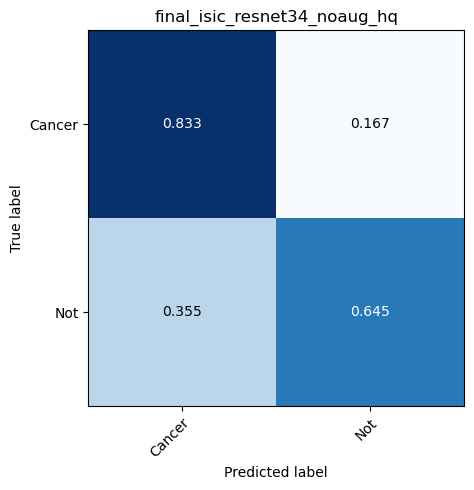

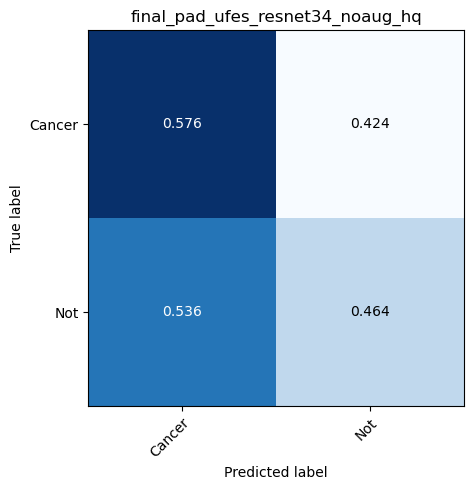

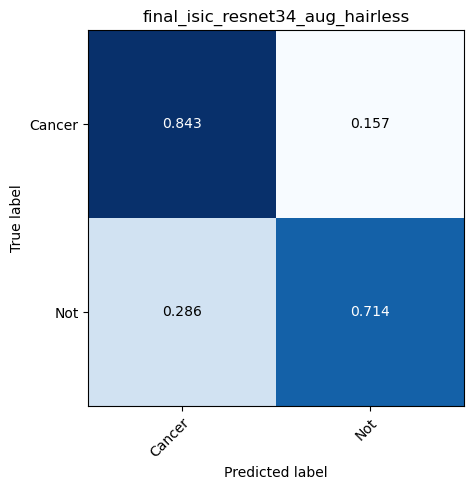

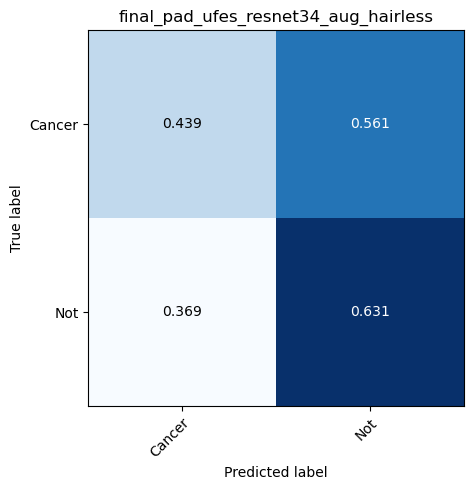

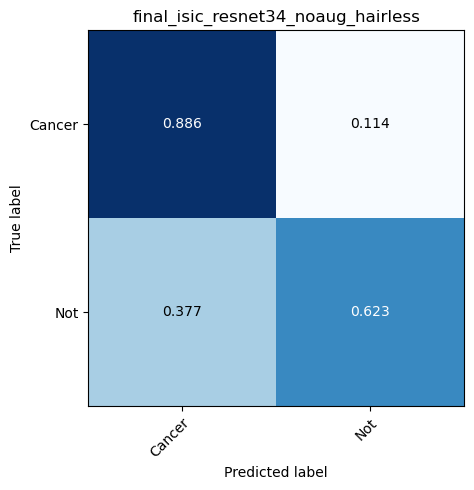

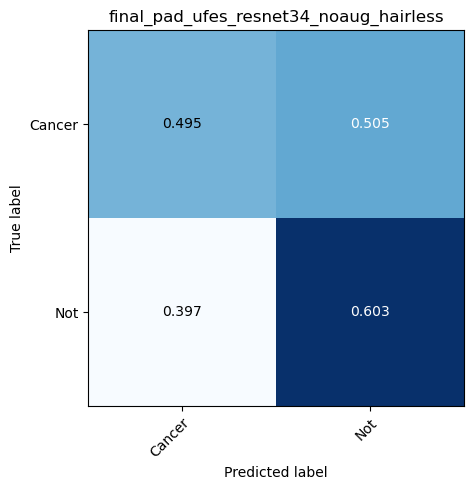

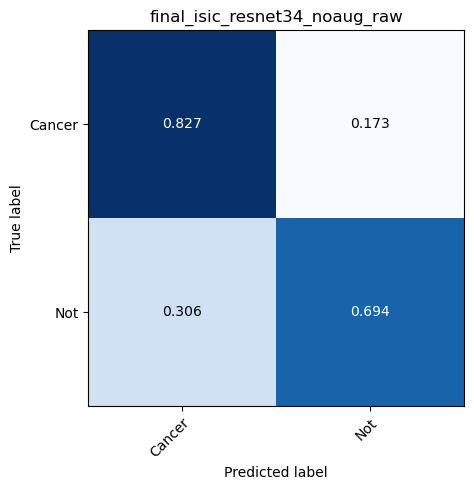

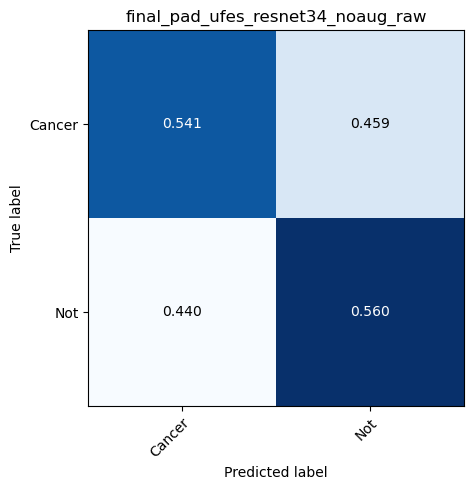

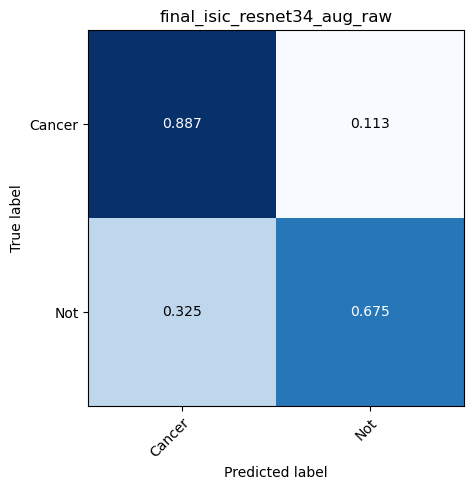

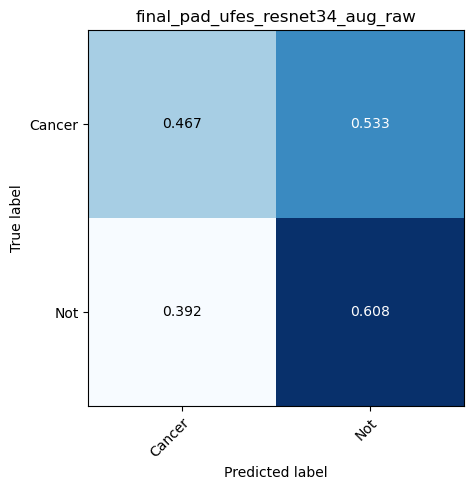

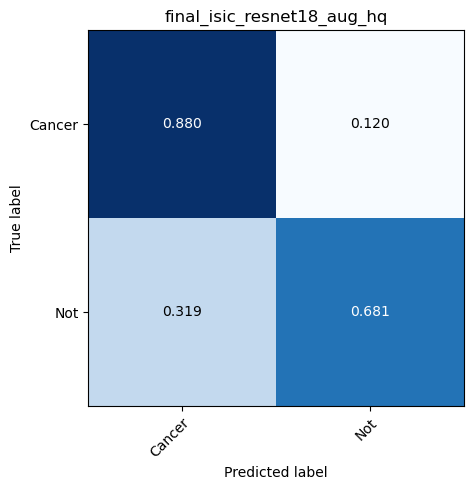

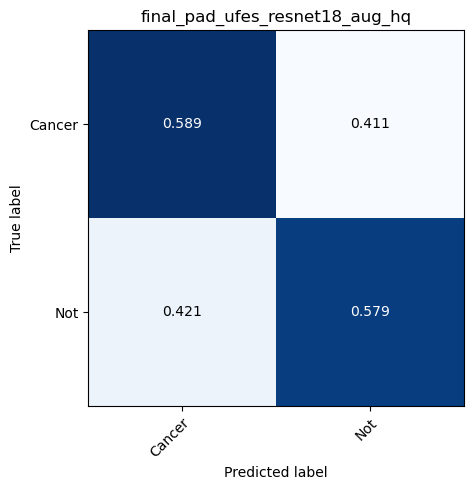

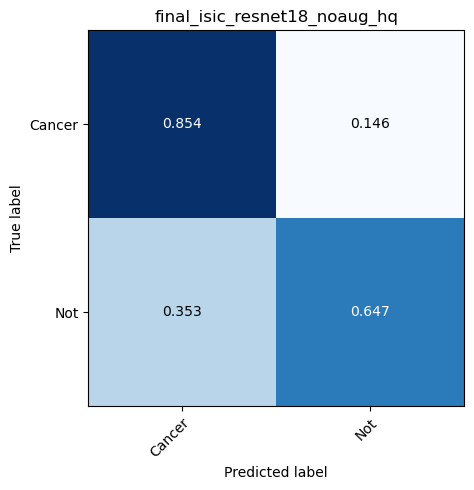

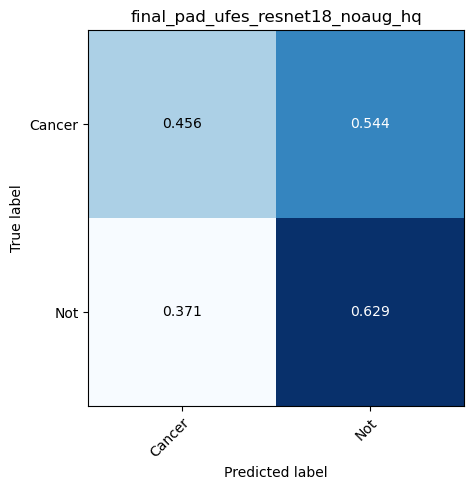

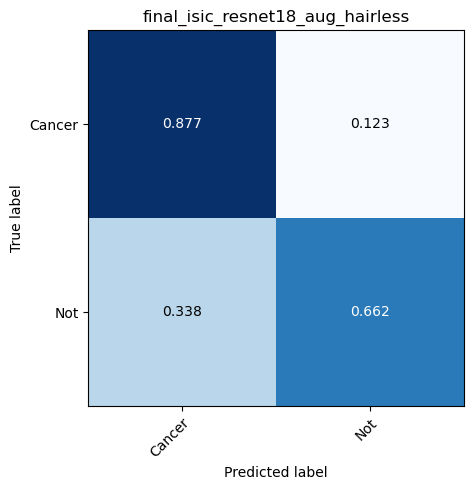

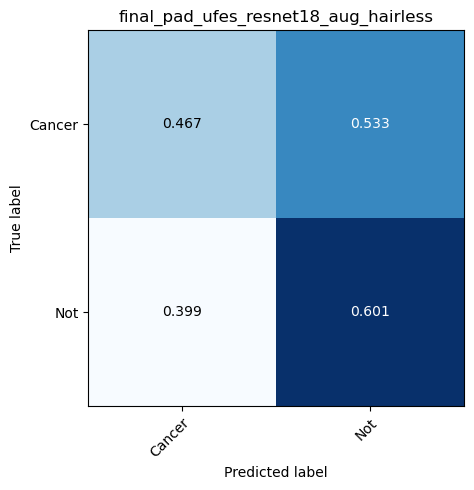

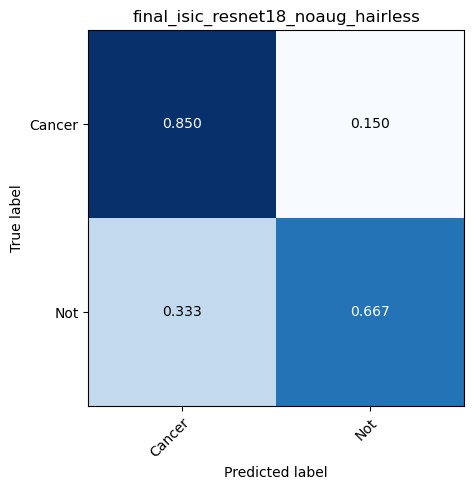

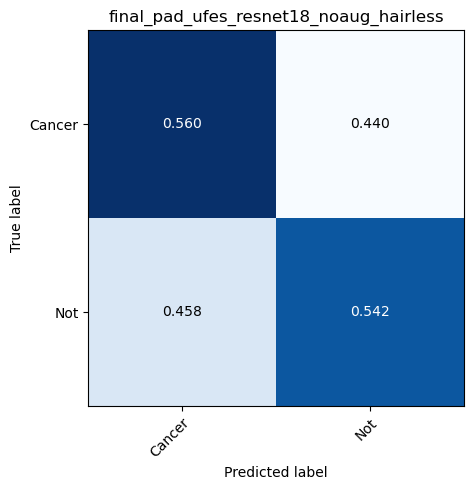

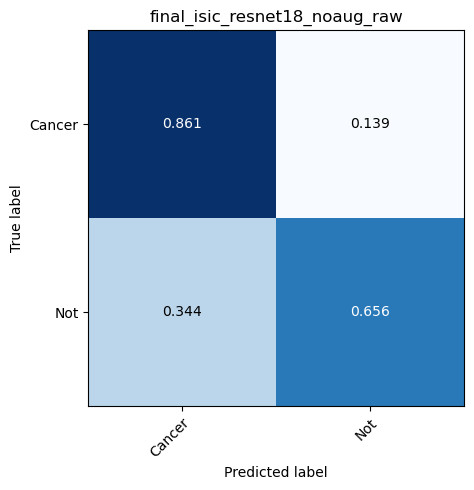

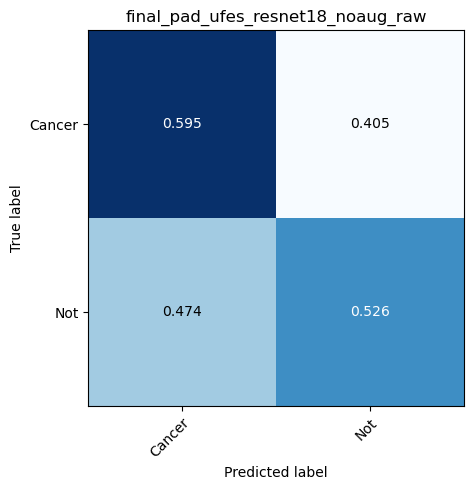

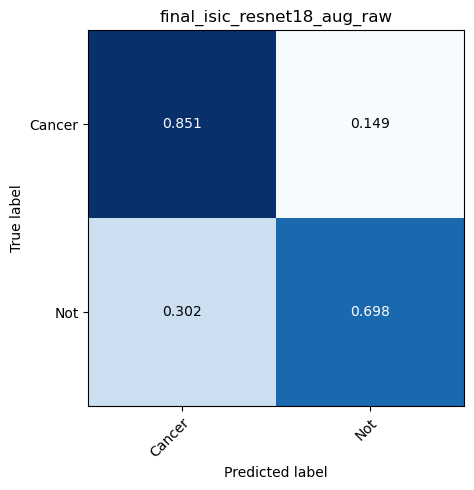

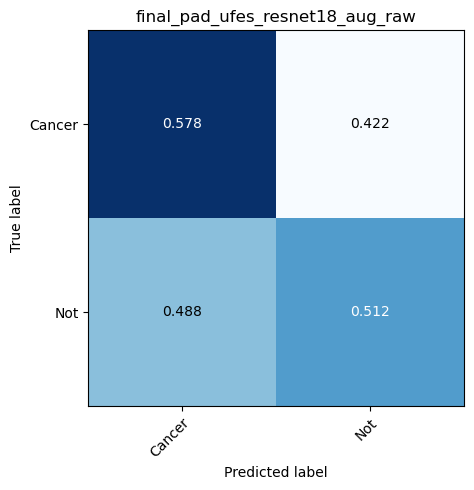

In [7]:
EXPERIMENT_DIR = DATA_DIR / 'experiments_strongaug'
perf_isic_on_isic = dict()
perf_pad_on_isic = dict()
cnt = Counter(isic_vals_raw['y_test'])
ratio = cnt['Cancer'] / (cnt["Cancer"] + cnt["Not"])
ratio = 1-ratio if ratio < 0.5 else ratio
for mod in ['resnet34', 'resnet18']:
    # hq
    for style in ['aug_hq', 'noaug_hq']:
        try:
            model_path = EXPERIMENT_DIR / 'final_isic' / mod / style
            model = load_model(model_path)
            title = "final_isic_{}_{}".format(mod , style)
            acc = evaluate_model_performance(model, title, **isic_vals_hq)
            perf_isic_on_isic[title] = acc

            model_path = EXPERIMENT_DIR / 'final_pad_ufes' / mod / style
            model = load_model(model_path)
            title = "final_pad_ufes_{}_{}".format(mod , style)
            acc = evaluate_model_performance(model, title, **isic_vals_hq)
            perf_pad_on_isic[title] = acc
        except (OSError, FileNotFoundError) as e:
            continue
    # hairless
    for style in ['aug_hairless', 'noaug_hairless']:
        try:
            model_path = EXPERIMENT_DIR / 'final_isic' / mod / style
            model = load_model(model_path)
            title = "final_isic_{}_{}".format(mod , style)
            acc = evaluate_model_performance(model, title, **isic_vals_hairless)
            perf_isic_on_isic[title] = acc

            model_path = EXPERIMENT_DIR / 'final_pad_ufes' / mod / style
            model = load_model(model_path)
            title = "final_pad_ufes_{}_{}".format(mod , style)
            acc = evaluate_model_performance(model, title, **isic_vals_hairless)
            perf_pad_on_isic[title] = acc
        except (OSError, FileNotFoundError) as e:
            continue
    # raw
    for style in ['noaug_raw', 'aug_raw']:
        try:
            model_path = EXPERIMENT_DIR / 'final_isic' / mod / style
            model = load_model(model_path)
            title = "final_isic_{}_{}".format(mod , style)
            acc = evaluate_model_performance(model, title, **isic_vals_raw)
            perf_isic_on_isic[title] = acc

            model_path = EXPERIMENT_DIR / 'final_pad_ufes' / mod / style
            model = load_model(model_path)
            title = "final_pad_ufes_{}_{}".format(mod , style)
            acc = evaluate_model_performance(model, title, **isic_vals_raw)
            perf_pad_on_isic[title] = acc
        except (OSError, FileNotFoundError) as e:
            continue
print("Class ratio is {:.3f}%".format(100*ratio))
print("Isic-on-Isic")
ordered_perf = sorted(perf_isic_on_isic.items(), key=lambda x: x[1], reverse=True)
for m, acc in ordered_perf:
    print("{}:\t\t{}".format(m, acc))
total_dict['isic-on-isic'] = ordered_perf
print("Pad-on-Isic")
ordered_perf = sorted(perf_pad_on_isic.items(), key=lambda x: x[1], reverse=True)
for m, acc in ordered_perf:
    print("{}:\t\t{}".format(m, acc))
total_dict['pad-on-isic'] = ordered_perf

In [11]:
for k,v in total_dict.items():
    for m, acc in v:
        print("{}:\t {}:\t {}".format(k, m, acc))
    print("")

isic-on-pad:	 final_isic_resnet18_aug_raw:	 0.6891304347826087
isic-on-pad:	 final_isic_resnet34_aug_hairless:	 0.6652173913043479
isic-on-pad:	 final_isic_resnet34_aug_raw:	 0.6326086956521739
isic-on-pad:	 final_isic_resnet18_noaug_hairless:	 0.6065217391304348
isic-on-pad:	 final_isic_resnet18_aug_hq:	 0.5956521739130435
isic-on-pad:	 final_isic_resnet18_aug_hairless:	 0.5652173913043478
isic-on-pad:	 final_isic_resnet34_noaug_hq:	 0.558695652173913
isic-on-pad:	 final_isic_resnet18_noaug_hq:	 0.558695652173913
isic-on-pad:	 final_isic_resnet34_noaug_hairless:	 0.55
isic-on-pad:	 final_isic_resnet34_noaug_raw:	 0.5413043478260869
isic-on-pad:	 final_isic_resnet18_noaug_raw:	 0.5304347826086957

pad-on-pad:	 final_pad_ufes_resnet34_aug_raw:	 0.7891304347826087
pad-on-pad:	 final_pad_ufes_resnet18_aug_raw:	 0.7804347826086957
pad-on-pad:	 final_pad_ufes_resnet18_aug_hq:	 0.7739130434782608
pad-on-pad:	 final_pad_ufes_resnet34_aug_hairless:	 0.7521739130434782
pad-on-pad:	 final_pad_uf

In [1]:
final = dict()
for k,v in total_dict.items():
    for m, acc in v:
        final[k+"_"+m] = acc
print(final)

NameError: name 'total_dict' is not defined